<font size="5"><center> <b>Sandpyper: sandy beaches SfM-UAV analysis tools</b></center></font>
<font size="4"><center> <b> Example 1 - Profiles extraction </b></center> <br>

    
<center><img src="images/banner.png" width="80%"  /></center>

<font face="Calibri">
<br>
<font size="5"> <b>Profiles creation and data extraction from DSM and orthophotos</b></font>

<br>
<font size="4"> <b> Nicolas Pucino; PhD Student @ Deakin University, Australia </b> <br>

<font size="3">The first steps in a typical workflow is to create cross-shore transects in all the locations and extract elevation and RGB information along those transects. Sandpiper allows the data extraction from hundreds of rasters at once, in an organised way. <br>

<b>This notebook covers the following concepts:</b>

- Naming conventions and global parameters.
- Setting up the folders.
- Setting up the folders.
</font>


</font>

Import all it is required.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import pickle
from tqdm.notebook import tqdm

from sandpyper.profile import ProfileSet
from sandpyper.hotspot import ProfileDynamics

pd.options.mode.chained_assignment = None  # default='warn'

C:\conda3\envs\sandpyper_env\lib\site-packages\pysal\explore\segregation\network\network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
C:\conda3\envs\sandpyper_env\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql
C:\conda3\envs\sandpyper_env\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
dirNameDSM=r'C:\my_packages\sandpyper\tests\test_data\dsm_1m'
dirNameOrtho=r'C:\my_packages\sandpyper\tests\test_data\orthos_1m'
dirNameTrans=r'C:\my_packages\sandpyper\tests\test_data\transects'
transects_spacing=20

loc_codes=["mar","leo"]
loc_search_dict = {   'leo': ['St','Leonards','leonards','leo'],
                      'mar': ['Marengo','marengo','mar'] }
crs_dict_string= {
                 'mar': {'init': 'epsg:32754'},
                 'leo':{'init': 'epsg:32755'}
                 }
lod_mode=r"C:\my_packages\sandpyper\tests\test_data\lod_transects"

D=pickle.load(open(r"C:\my_packages\sandpyper\tests\test_data\test.p", "rb"))

loc_subset=["mar"] # the function is optimised for single-location plots, but you can also pass a list of location codes
colors_dict={"mar":'r',        # if you use multiple locations, then dictionary key is the location code and value the color
            "leo":'b'}

In [3]:
D.compute_multitemporal(loc_full={'mar': 'Marengo',
         'leo': 'St. Leonards'}, filter_class='sand')

Filter activated: only ['sand'] points will be retained.
working on leo


  0%|          | 0/6 [00:00<?, ?it/s]

Calculating dt0, from 20180606 to 20180713 in leo.
Calculating dt1, from 20180713 to 20180920 in leo.
Calculating dt2, from 20180920 to 20190211 in leo.
Calculating dt3, from 20190211 to 20190328 in leo.
Calculating dt4, from 20190328 to 20190731 in leo.
working on mar


  0%|          | 0/9 [00:00<?, ?it/s]

Calculating dt0, from 20180601 to 20180621 in mar.
Calculating dt1, from 20180621 to 20180727 in mar.
Calculating dt2, from 20180727 to 20180925 in mar.
Calculating dt3, from 20180925 to 20181113 in mar.
Calculating dt4, from 20181113 to 20181211 in mar.
Calculating dt5, from 20181211 to 20190205 in mar.
Calculating dt6, from 20190205 to 20190313 in mar.
Calculating dt7, from 20190313 to 20190516 in mar.
done
working on mar


  0%|          | 0/9 [00:00<?, ?it/s]

Calculating dt0, from 20180601 to 20180621 in mar.
Calculating dt1, from 20180621 to 20180727 in mar.
Calculating dt2, from 20180727 to 20180925 in mar.
Calculating dt3, from 20180925 to 20181113 in mar.
Calculating dt4, from 20181113 to 20181211 in mar.
Calculating dt5, from 20181211 to 20190205 in mar.
Calculating dt6, from 20190205 to 20190313 in mar.
Calculating dt7, from 20190313 to 20190516 in mar.
working on leo


  0%|          | 0/6 [00:00<?, ?it/s]

Calculating dt0, from 20180606 to 20180713 in leo.
Calculating dt1, from 20180713 to 20180920 in leo.
Calculating dt2, from 20180920 to 20190211 in leo.
Calculating dt3, from 20190211 to 20190328 in leo.
Calculating dt4, from 20190328 to 20190731 in leo.
done


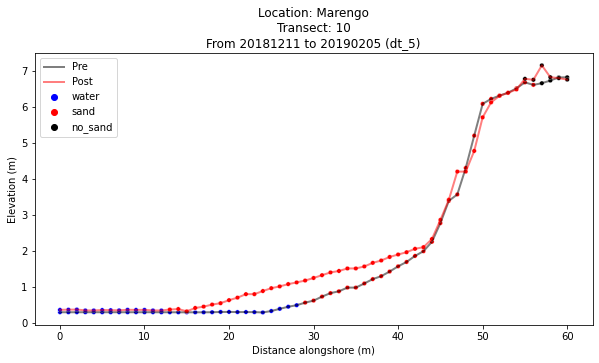

In [4]:
D.plot_transects(location='mar',tr_id=10, dt='dt_5', classified=True)

Working on leo at dt_0


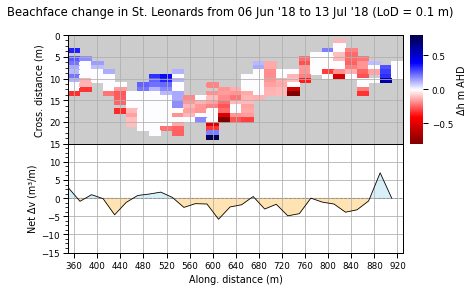

Working on leo at dt_1


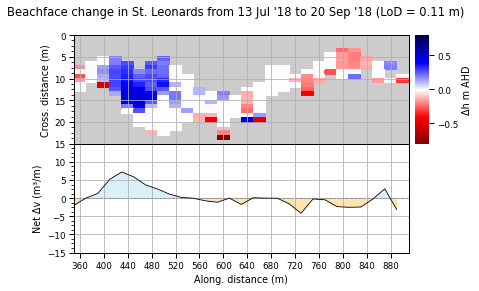

Working on leo at dt_2


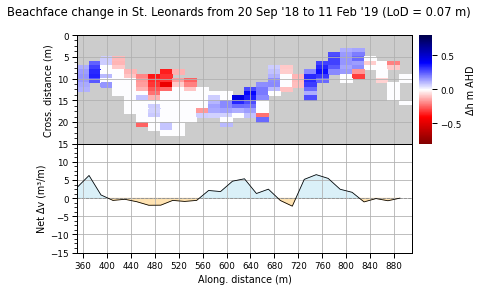

In [5]:
mode="subset" # if 'subset', only the provided location_subset and dt_subset will be plotted. If 'all', plot all.
location_subset=['leo'] # provide a list of location codes. Only these locations will be plotted
y_heat_bottom_limit=25 # bottom limit of the heatmaps (altimetric change)
heat_yticklabels_freq=5
heat_xticklabels_freq=2
ax2_y_lims=[-15,15] # axis limit of the alongshore volumetric plot
dt_subset=["dt_0", "dt_1","dt_2"]

D.plot_alongshore_change(mode=mode, lod=D.lod_df,dt_subset=dt_subset,
                        location_subset=location_subset,
                        y_heat_bottom_limit=y_heat_bottom_limit,
                        heat_yticklabels_freq=heat_yticklabels_freq,
                         heat_xticklabels_freq=heat_xticklabels_freq,
                        ax2_y_lims=ax2_y_lims)

Statistics are computed based on the following classes only: sand


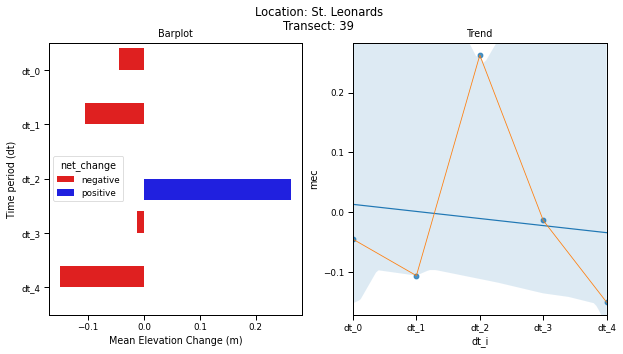

In [6]:
D.plot_transect_mecs('leo',tr_id=39)

Using LoDs.
Statistics are computed based on the following classes only: sand


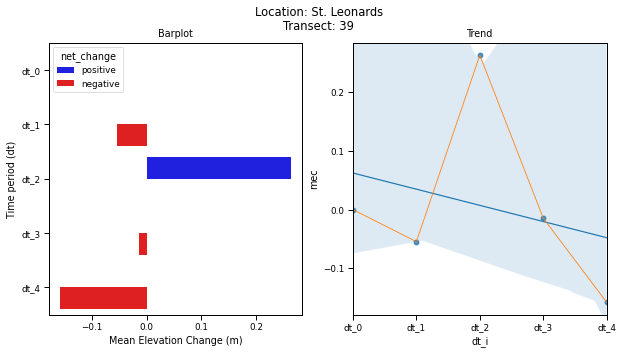

In [7]:
D.plot_transect_mecs('leo',tr_id=39, lod=D.lod_df)

In [16]:
D.compute_volumetrics(lod=D.lod_df)
D.location_volumetrics

,location,location_full,dt,date_from,date_to,n_days,abs_in,abs_out,abs_net_change,mec_m,norm_in,norm_out,norm_net_change,tot_vol_depo,tot_vol_ero,net_vol_change,location_m3_m,n_obs_valid
0,leo,St. Leonards,dt_0,20180606,20180713,37,9.489928,-20.506530,-11.016602,-0.018994,0.041082,-0.088773,-0.047691,134.334184,-362.662966,-228.328782,-0.393670,231
1,leo,St. Leonards,dt_1,20180713,20180920,69,18.725955,-9.525609,9.200346,0.016429,0.085507,-0.043496,0.042011,322.445395,-103.237953,219.207442,0.391442,219
2,leo,St. Leonards,dt_2,20180920,20190211,144,15.840791,-7.481373,8.359419,0.014928,0.076158,-0.035968,0.040190,285.138428,-138.500707,146.637721,0.261853,208
3,leo,St. Leonards,dt_3,20190211,20190328,45,10.163696,-11.862978,-1.699282,-0.002930,0.040015,-0.046705,-0.006690,181.204725,-171.608277,9.596448,0.016546,254
4,leo,St. Leonards,dt_4,20190328,20190731,125,6.105440,-29.049858,-22.944418,-0.040972,0.026896,-0.127973,-0.101077,89.599553,-511.175997,-421.576444,-0.752815,227
5,mar,Marengo,dt_0,20180601,20180621,20,47.933825,-30.648133,17.285693,0.041156,0.127824,-0.081728,0.046095,1030.634869,-606.379918,424.254951,1.010131,375
6,mar,Marengo,dt_1,20180621,20180727,36,25.375054,-46.167231,-20.792177,-0.049505,0.066776,-0.121493,-0.054716,536.013932,-1095.568154,-559.554222,-1.332272,380
7,mar,Marengo,dt_2,20180727,20180925,60,144.146997,-38.435384,105.711614,0.251694,0.367722,-0.098049,0.269672,2860.189079,-760.660241,2099.528838,4.998878,392
8,mar,Marengo,dt_3,20180925,20181113,49,25.104553,-35.649872,-10.545319,-0.023967,0.105040,-0.149163,-0.044123,492.032262,-717.083270,-225.051008,-0.511480,239
9,mar,Marengo,dt_4,20181113,20181211,28,48.356887,-4.653221,43.703666,0.099327,0.209337,-0.020144,0.189193,893.964017,-141.652205,752.311812,1.709800,231


In [17]:
D.compute_volumetrics(lod=None)
D.location_volumetrics

,location,location_full,dt,date_from,date_to,n_days,abs_in,abs_out,abs_net_change,mec_m,norm_in,norm_out,norm_net_change,tot_vol_depo,tot_vol_ero,net_vol_change,location_m3_m,n_obs_valid
0,leo,St. Leonards,dt_0,20180606,20180713,37,10.323267,-23.795113,-13.471845,-0.023227,0.044689,-0.103009,-0.058320,149.572205,-398.448784,-248.876579,-0.429098,231
1,leo,St. Leonards,dt_1,20180713,20180920,69,20.625028,-11.409182,9.215845,0.016457,0.094178,-0.052097,0.042081,382.344291,-163.748037,218.596254,0.390350,219
2,leo,St. Leonards,dt_2,20180920,20190211,144,16.458533,-8.027606,8.430927,0.015055,0.079128,-0.038594,0.040533,291.875816,-157.124944,134.750872,0.240627,208
3,leo,St. Leonards,dt_3,20190211,20190328,45,11.911923,-14.268533,-2.356610,-0.004063,0.046897,-0.056175,-0.009278,246.130330,-284.623295,-38.492966,-0.066367,254
4,leo,St. Leonards,dt_4,20190328,20190731,125,8.350759,-30.195398,-21.844640,-0.039008,0.036787,-0.133019,-0.096232,141.301677,-534.854452,-393.552776,-0.702773,227
5,mar,Marengo,dt_0,20180601,20180621,20,47.080817,-30.190215,16.890602,0.040216,0.125549,-0.080507,0.045042,1023.074357,-551.946541,471.127816,1.121733,375
6,mar,Marengo,dt_1,20180621,20180727,36,25.375054,-46.167231,-20.792177,-0.049505,0.066776,-0.121493,-0.054716,536.013932,-1095.568154,-559.554222,-1.332272,380
7,mar,Marengo,dt_2,20180727,20180925,60,143.913355,-37.840407,106.072948,0.252555,0.367126,-0.096532,0.270594,2842.428631,-751.125486,2091.303145,4.979293,392
8,mar,Marengo,dt_3,20180925,20181113,49,25.550511,-37.228701,-11.678190,-0.026541,0.106906,-0.155769,-0.048863,504.537241,-739.151502,-234.614261,-0.533214,239
9,mar,Marengo,dt_4,20181113,20181211,28,49.116777,-5.773403,43.343374,0.098508,0.212627,-0.024993,0.187634,913.987438,-176.205276,737.782163,1.676778,231


Color dictionary provided.


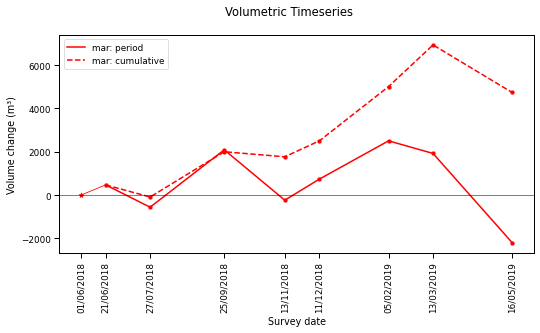

In [14]:
D.plot_single_loc(['mar'], colors_dict=colors_dict)

Color dictionary provided.


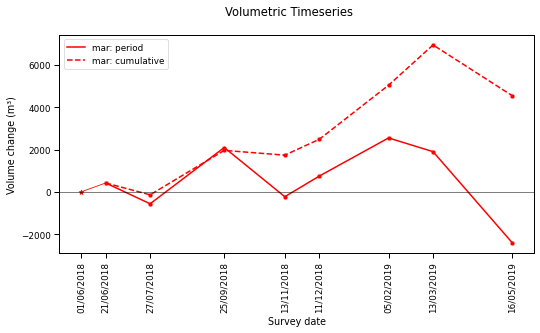

In [9]:
D.plot_single_loc(['mar'], colors_dict=colors_dict)

In [15]:
data=D.dh_df.query(f"location=='{location}' and tr_id=={tr_id}").copy()

lods=D.lod_df.query(f"location=='{location}'")[["dt","lod"]]
data=pd.merge(data,lods, how='left', on='dt')
data["dh_abs"]=[abs(dh_i) for dh_i in data.dh]
data["dh"]=np.where(data.dh_abs<data.lod, 0,data.dh)
data.drop('dh_abs', axis=1, inplace=True)
data.iloc[101]

NameError: name 'location' is not defined

In [23]:
mecs['net']=['positive' if mec_i >=0 else 'negative' for mec_i in mecs.mec]
mecs

,dt,mec,dt_i,net
0,dt_0,-0.041592,0,negative
1,dt_1,0.155148,1,positive
2,dt_2,-0.298516,2,negative
3,dt_3,0.399428,3,positive
4,dt_4,-0.041660,4,negative
5,dt_5,0.173740,5,positive
6,dt_6,0.289967,6,positive
7,dt_7,-0.188238,7,negative


Statistics are computed based on the following classes only: sand


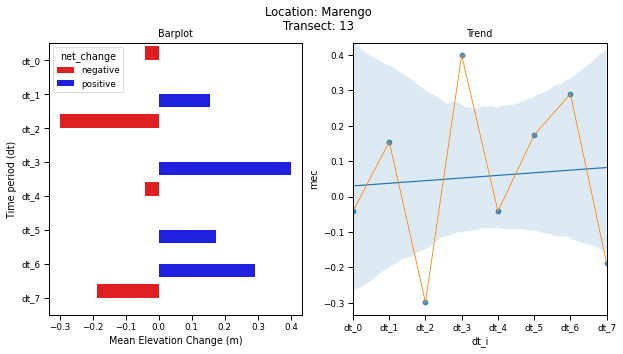

In [33]:
import seaborn as sb

location='mar'
tr_id=13
lod=None

details=D.dh_details.query(f"location=='{location}'")
full_loc=details.iloc[0]["loc_full"]

f,axs=plt.subplots(nrows=1,
                  ncols=2,
                  figsize=(10,5))



data=D.dh_df.query(f"location=='{location}' and tr_id=={tr_id}")


filter_used=D.dh_df.class_filter.unique()[0]
if filter_used != "no_filters_applied":
    print(f"Statistics are computed based on the following classes only: {filter_used}")

mecs=data.groupby(['dt']).dh.sum()/data.groupby(['dt']).geometry.count()
mecs=mecs.reset_index()
mecs.columns=['dt','mec']
mecs['dt_i']=[int(mecs.iloc[i,0].split("_")[-1]) for i in range(mecs.dt.shape[0])]
mecs['net_change']=['positive' if mec_i >=0 else 'negative' for mec_i in mecs.mec]


barplot=sb.barplot(data=mecs.sort_values(['dt_i']),x='mec',y='dt', ax=axs[0],
                   hue='net_change', palette={'positive':'b','negative': 'r'})

barplot.set_ylabel("Time period (dt)")
barplot.set_xlabel("Mean Elevation Change (m)")
barplot.set_title('Barplot')

trend=sb.regplot(data=mecs, x='dt_i',y='mec',ax=axs[1])
sb.lineplot(data=mecs, x='dt',y='mec',ax=axs[1])
trend.set_title('Trend')

f.suptitle(f"Location: {full_loc}\nTransect: {tr_id}");

Statistics are computed based on the following classes only: sand


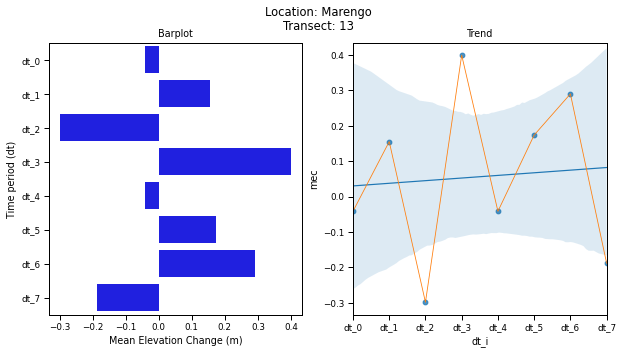

In [23]:
D.plot_transect_mecs('mar',tr_id=13)

### Sensitivity Analysis r-bcd transects

In [ ]:
from sandpyper.dynamics import get_rbcd_transect
import seaborn as sb
from tqdm.notebook import tqdm_notebook as tqdm

In [ ]:
import itertools

In [ ]:
range_thresh=range(0,data_in.dt.unique().shape[0]+1)
range_min_pts=range(0,50,10)
combs = list(itertools.product(range_min_pts,range_thresh))

In [ ]:
ss_tr_big=pd.DataFrame()

for i in tqdm(combs):
    print(f"Working on threshold {i[1]} and min points {i[0]}.")
    
    ss_transects_idx = get_rbcd_transect(df_labelled=data_in,
              thresh=i[1], min_points=i[0], reliable_action='drop',
              dirNameTrans=D.ProfileSet.dirNameTrans,
              labels_order=D.tags_order,
              loc_codes=D.ProfileSet.loc_codes,
              crs_dict_string=D.ProfileSet.crs_dict_string)

    ss_transects_idx['thresh']=i[1]
    ss_transects_idx['min_pts']=i[0]

    ss_tr_big=pd.concat([ss_tr_big,ss_transects_idx], ignore_index=True)
    
ss_tr_big

In [ ]:
f,ax=plt.subplots(figsize=(10,10))

palette=sb.color_palette( n_colors=ss_tr_big.tr_id.unique().shape[0])
sb.lineplot(data=ss_tr_big, x='thresh',y='residual', hue='tr_id',
            palette=palette, legend=False, **dict(alpha=0.1),
            ax=ax
)
ax.set_ylabel("r_bcd")
ax.axhline(y=0, lw=2, c='r');

In [ ]:
trs_res_ar=ss_tr_big_loc.groupby(["tr_id","min_pts"])['residual'].apply(np.array).reset_index()
tot_trs=ss_tr_big_loc.groupby(["thresh","min_pts"])['geometry'].count().reset_index()
tot_trs['trs_10']=tot_trs.geometry / 10
zero_crossings=pd.DataFrame([pd.Series({'tr_id':trs_res_ar.loc[i,'tr_id'],
                                        'sign_change_thresh':np.where(np.diff(np.sign(trs_res_ar.iloc[i,-1])))[0][-1]+1,
                                       'min_pts':trs_res_ar.loc[i,'min_pts']}) for i in range(trs_res_ar.shape[0]) if np.where(np.diff(np.sign(trs_res_ar.iloc[i,-1])))[0].shape[0] !=0])
tot_jumps=zero_crossings.groupby(["sign_change_thresh","min_pts"]).count().reset_index() # how many jumps per thresh and minpts

joined=pd.merge(tot_trs,tot_jumps, left_on=['thresh','min_pts'], right_on=['sign_change_thresh','min_pts'], how='left')
joined.rename({'geometry':'tot_trs',
              'tr_id':'tot_jumps'}, axis=1, inplace=True)
joined

In [ ]:
plt.rcParams['font.sans-serif'] = 'Arial'
# Then, "ALWAYS use sans-serif fonts"
plt.rcParams['font.family'] = 'sans-serif'
sb.set_context("paper", font_scale=2.8)


x_ticks=[0,2,4,6,8]

q_up_val=0.95
q_low_val=0.85

list_minpts=ss_tr_big.min_pts.unique()

for minpts in list_minpts:

    f,ax=plt.subplots(figsize=(7,4))
    ax2=ax.twinx()
    
    datain=joined.query(f"min_pts=={minpts}")  


    sb.lineplot(x="thresh", y="tot_jumps",ci=None,
                    data=datain,color='b',
                   alpha=.4,linewidth=3,
                ax=ax2, label="sign changes")

    sb.lineplot(data=datain,x='thresh',y='trs_10',
                alpha=.4,color='r',linewidth=3,
                ax=ax,label="transects * 10")
    
    
    kde_x, kde_y = ax.lines[0].get_data()
    kde_x2, kde_y2 = ax2.lines[0].get_data()
    ax.fill_between(kde_x, kde_y,interpolate=True, color='r',alpha=0.5)
    ax2.fill_between(kde_x2, kde_y2,interpolate=True,color='b',alpha=0.5)
    
    ax.axhline((datain.tot_trs.fillna(0).max()*q_up_val)/10,c='k',ls='-',label='95%')
    ax.axhline((datain.tot_trs.fillna(0).max()*q_low_val)/10,c='k',lw=2.5,ls='--',label='85%')
    
    ax.set_ylabel('n. transects x 10', c='r')
    ax.set_xlabel('t')
    ax2.set_ylabel('sign changes', c='b')
    ax2.set_ylim(0,3)
    ax.set_ylim(0,3)
    ax.set_xlim(0,8)
    

    plt.tight_layout()
    ax.get_legend().remove()
    ax2.get_legend().remove()
    
    
    plt.xticks(x_ticks)
    savetxt=f"E:\\path\\to\\save\\revision_0\\location_sensit_minpts_{minpts}.png"
    
    ax.set_title(f"pt: {minpts}")
    plt.tight_layout()
    
#   f.savefig(savetxt, dpi=600); #uncomment to save all images

### ProfileSet

In [ ]:
P=ProfileSet(dirNameDSM=dirNameDSM,
            dirNameOrtho=dirNameOrtho,
            dirNameTrans=dirNameTrans,
            transects_spacing=transects_spacing,
            loc_codes=loc_codes,
            loc_search_dict=loc_search_dict,
            crs_dict_string=crs_dict_string,
            check="all")

In [ ]:
P.extract_profiles(mode='all',sampling_step=1,add_xy=True,lod_mode=lod_mode)

#### Cleaning

In [ ]:
from sandpyper.labels import get_sil_location, get_opt_k


In [ ]:
# Run interatively KMeans + SA

feature_set=["band1","band2","band3","distance"]
sil_df=get_sil_location(P.profiles,
                        ks=(2,15), 
                        feature_set=feature_set,
                       random_state=10)
sil_df

In [ ]:
opt_k=get_opt_k(sil_df, sigma=0 )
opt_k

In [ ]:
P.kmeans_sa(opt_k,feature_set)

In [ ]:
water_dict={'leo_20180606':[0,9,10],
'leo_20180713':[0,3,4,7],
'leo_20180920':[0,2,6,7],
'leo_20190211':[0,2,5],
'leo_20190328':[2,4,5],
'leo_20190731':[0,2,8,6],
'mar_20180601':[1,6],
'mar_20180621':[4,6],
'mar_20180727':[0,5,9,10],
'mar_20180925':[0],
'mar_20181113':[1],
'mar_20181211':[4],
'mar_20190205':[],
'mar_20190313':[],
'mar_20190516':[4,7]}

no_sand_dict={'leo_20180606':[5],
'leo_20180713':[],
'leo_20180920':[],
'leo_20190211':[1],
'leo_20190328':[],
'leo_20190731':[1],
'mar_20180601':[4,5],
'mar_20180621':[3,5],
'mar_20180727':[4,7],
'mar_20180925':[1,6],
'mar_20181113':[0],
'mar_20181211':[0],
'mar_20190205':[0,5],
'mar_20190313':[4],
'mar_20190516':[2,5]}

veg_dict={'leo_20180606':[1,3,7,8],
'leo_20180713':[1,5,9],
'leo_20180920':[1,4,5],
'leo_20190211':[4],
'leo_20190328':[0,1,6],
'leo_20190731':[3,7],
'mar_20180601':[0,7],
'mar_20180621':[1,7],
'mar_20180727':[1,3],
'mar_20180925':[4],
'mar_20181113':[3],
'mar_20181211':[2],
'mar_20190205':[3],
'mar_20190313':[1,5],
'mar_20190516':[0]}

sand_dict={'leo_20180606':[2,4,6],
'leo_20180713':[2,6,8],
'leo_20180920':[3],
'leo_20190211':[3],
'leo_20190328':[3],
'leo_20190731':[4,5],
'mar_20180601':[2,3],
'mar_20180621':[0,2],
'mar_20180727':[2,6,8],
'mar_20180925':[2,3,5],
'mar_20181113':[2,4],
'mar_20181211':[3,1],
'mar_20190205':[1,2,4],
'mar_20190313':[0,2,3],
'mar_20190516':[1,3,6]}


l_dicts={'no_sand': no_sand_dict,
         'sand': sand_dict,
        'water': water_dict,
        'veg':veg_dict}

In [ ]:
label_corrections_path=r"C:\my_packages\sandpyper\tests\test_data\label_corrections.gpkg"
watermasks_path=r"C:\my_packages\sandpyper\tests\test_data\watermasks.gpkg"
shoremasks_path=r"C:\my_packages\sandpyper\tests\test_data\shoremasks.gpkg"

In [ ]:
P.cleanit(l_dicts=l_dicts,
          watermasks_path=watermasks_path,
          shoremasks_path=shoremasks_path,
          label_corrections_path=label_corrections_path)

### ProfileDynamics

In [ ]:
labels=["Undefined", "Small", "Medium", "High", "Extreme"]
appendix=["_deposition", "_erosion"]


D = ProfileDynamics(P, bins=5, method="JenksCaspall", labels=labels)

D.compute_multitemporal(loc_full={'mar': 'Marengo',
         'leo': 'St. Leonards'}, filter_class='sand')

D.LISA_site_level(mode="distance", distance_value=35)

D.discretise(absolute=True, print_summary=True)

D.infer_weights()

D.BCD_compute_location("geometry","all",True)

In [ ]:
relabel_dict={"Undefined_erosion":"ue",
"Small_erosion":"se",
"Medium_erosion":"me",
"High_erosion":"he",
"Extreme_erosion":"ee",
 "Undefined_deposition":"ud",
 "Small_deposition":"sd",
 "Medium_deposition":"md",
 "High_deposition":"hd",
 "Extreme_deposition":"ed"
}

D.plot_trans_matrices(relabel_dict)

In [ ]:
D.BCD_compute_location(unique_field='geometry',mode='all', store_neg=True)

In [ ]:
D.compute_volumetrics(lod=D.lod_df)

In [ ]:
loc_subset=["mar"] # the function is optimised for single-location plots, but you can also pass a list of location codes
colors_dict={"mar":'r',        # if you use multiple locations, then dictionary key is the location code and value the color
            "leo":'b'}

In [ ]:
D.plot_transects(location='mar', tr_id=10, dt=['dt_0','dt_2'], classified=False)

In [ ]:
D.plot_transects(location='mar', tr_id=10, dt=['dt_0','dt_2'], classified=True)

In [ ]:
D.plot_transect_mecs(location='leo',tr_id=28)

In [ ]:
D.plot_single_loc(["mar"],None)

In [ ]:
mode="subset" # if 'subset', only the provided location_subset and dt_subset will be plotted. If 'all', plot all.
location_subset=['mar'] # provide a list of location codes. Only these locations will be plotted
y_heat_bottom_limit=9 # bottom limit of the heatmaps (altimetric change)
ax2_y_lims=[-1.5,1.5] # axis limit of the alongshore volumetric plot
dt_subset=["dt_0","dt_3"]

D.plot_alongshore_change(mode=mode, lod=0.05,dt_subset=dt_subset,
                        location_subset=location_subset,
                        y_heat_bottom_limit=y_heat_bottom_limit,
                        ax2_y_lims=ax2_y_lims)

In [ ]:
D.plot_mec_evolution(location_field="location",
                     loc_order=["leo","mar"])

In [ ]:
D.BCD_compute_transects(thresh=7, min_points=20,reliable_action='keep', dirNameTrans=D.ProfileSet.dirNameTrans)

In [ ]:
D.transects_rbcd.query("location=='leo'").plot(column="residual", cmap='RdBu_r')

### Save

In [ ]:
dir_out=r'C:\my_packages\sandpyper\tests\test_data'
name="test"
D.save(name,dir_out)
D

### Load

In [ ]:
D=pickle.load(open(r"C:\my_packages\sandpyper\tests\test_data\test.p", "rb"))

loc_subset=["mar"] # the function is optimised for single-location plots, but you can also pass a list of location codes
colors_dict={"mar":'r',        # if you use multiple locations, then dictionary key is the location code and value the color
            "leo":'b'}

___